In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import torch 

from eeg_feature_extraction.eeg_utils import *
%matplotlib inline

In [15]:
# load embeddings
embeddings_45d = load_embeddings('binary', k = 15)
embeddings_90d = load_embeddings('binary', k = 30)

In [16]:
embeddings_45d_RF_NR, embeddings_45d_RF_TSR = embeddings_45d[2], embeddings_45d[3]
embeddings_90d_RF_NR, embeddings_90d_RF_TSR = embeddings_90d[2], embeddings_90d[3]

In [17]:
files_nr = get_matfiles('task2')
files_tsr = get_matfiles('task3')

data_nr = io.loadmat(files_nr[0], squeeze_me=True, struct_as_record=False)['sentenceData']
data_tsr = io.loadmat(files_tsr[0], squeeze_me=True, struct_as_record=False)['sentenceData']

sentences_nr = [sent.content.split() for i, sent in enumerate(data_nr) if i not in get_held_out_sents('task2')]
sentences_tsr = [sent.content.split() for i, sent in enumerate(data_tsr) if i not in get_held_out_sents('task3')]

In [18]:
def compute_word_weights(sent_embeddings:np.ndarray, computation:str, soft_attention=True, e=2):
    func = np.mean if computation == 'avg' else np.max
    word_weights = np.array(list(map(func, sent_embeddings)))
    # add small value to every weight to avoid multiplications or divisions by zero
    word_weights += 1e-5
    def softmax(e):
        return np.exp(e) / np.sum(np.exp(e))
    if soft_attention:
        word_weights = softmax(word_weights)
    else:
        # TODO: figure out whether this approach actually works (maybe attention weights have to represent proba distribution)
        # normalize weights by maximum sentence activity to get values in range [0, 1]
        word_weights /= np.max(word_weights)
        # divide word weights by some constant e to get smaller values and make computations more robust
        word_weights /= e
    return word_weights

In [19]:
def get_attention_weights(embeddings:np.ndarray, sentences:list, computation:str):
    n_sents, n_words = len(sentences), embeddings.shape[0]
    df = pd.DataFrame(index = range(0, n_words+n_sents), columns = ['word', 'eeg_weight'])
    cum_sent_len = 0
    cum_df_idx = 0
    for i, sent in enumerate(sentences):
        sent_length = len(sent)
        sent_embeddings = embeddings[cum_sent_len:cum_sent_len+sent_length]
        word_weights = compute_word_weights(sent_embeddings, computation)
        df.iloc[cum_df_idx:cum_df_idx+sent_length, 0] = sent
        df.iloc[cum_df_idx:cum_df_idx+sent_length, 1] = word_weights
        df.iloc[cum_df_idx+sent_length, :] = ' '
        cum_df_idx += sent_length + 1
        cum_sent_len += sent_length
    return df

In [27]:
weights_45d_RF_NR_Max = get_attention_weights(embeddings_45d_RF_NR, sentences_nr, 'max')
weights_45d_RF_TSR_Max = get_attention_weights(embeddings_45d_RF_TSR, sentences_tsr, 'max')

weights_90d_RF_NR_Max = get_attention_weights(embeddings_90d_RF_NR, sentences_nr, 'max')
weights_90d_RF_TSR_Max = get_attention_weights(embeddings_90d_RF_TSR, sentences_tsr, 'max')

In [28]:
weights_45d_RF_NR_Mean = get_attention_weights(embeddings_45d_RF_NR, sentences_nr, 'avg')
weights_45d_RF_TSR_Mean = get_attention_weights(embeddings_45d_RF_TSR, sentences_tsr, 'avg')

weights_90d_RF_NR_Mean = get_attention_weights(embeddings_90d_RF_NR, sentences_nr, 'avg')
weights_90d_RF_TSR_Mean = get_attention_weights(embeddings_90d_RF_TSR, sentences_tsr, 'avg')

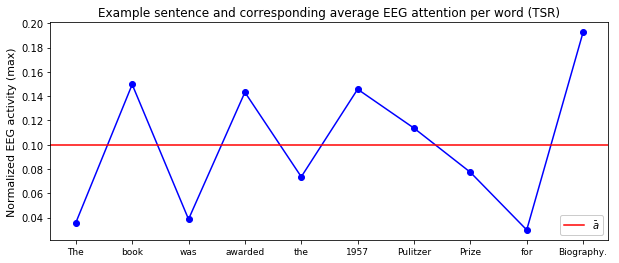

In [25]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Max[74:84])), weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_TSR_Max[74:84][:15])), weights_90d_RF_TSR_Max[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG attention per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

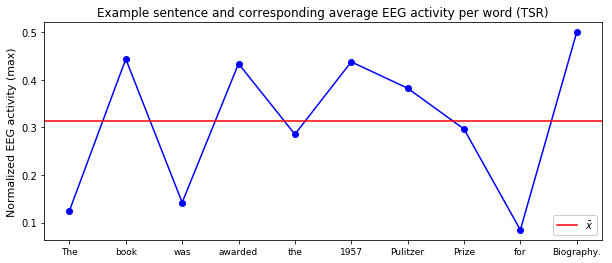

In [39]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Max[74:84])), weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar x$')
plt.xticks(range(len(weights_90d_RF_TSR_Max[74:84][:15])), weights_90d_RF_TSR_Max[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

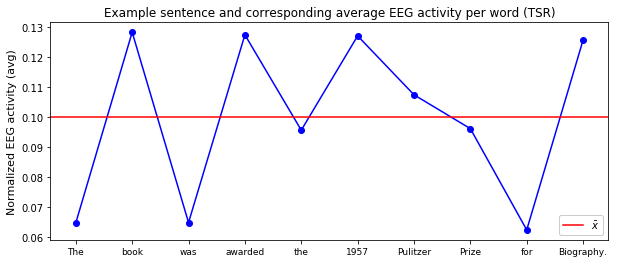

In [26]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Mean[74:84])), weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar x$')
plt.xticks(range(len(weights_90d_RF_TSR_Mean[74:84][:15])), weights_90d_RF_TSR_Mean[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

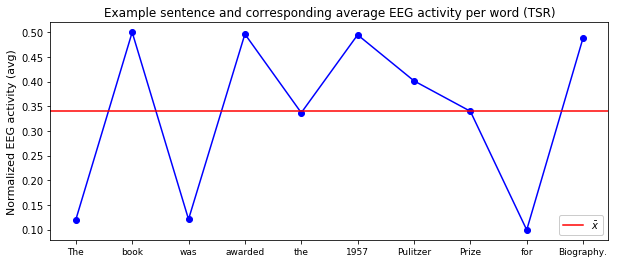

In [40]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Mean[74:84])), weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar x$')
plt.xticks(range(len(weights_90d_RF_TSR_Mean[74:84][:15])), weights_90d_RF_TSR_Mean[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

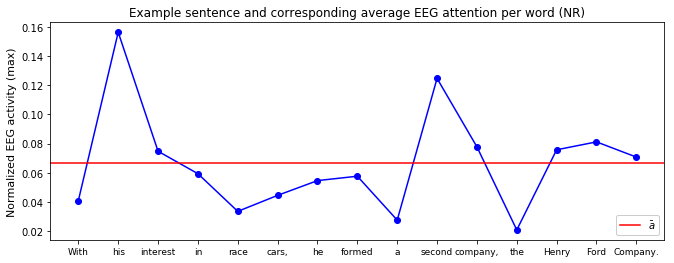

In [30]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG attention per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

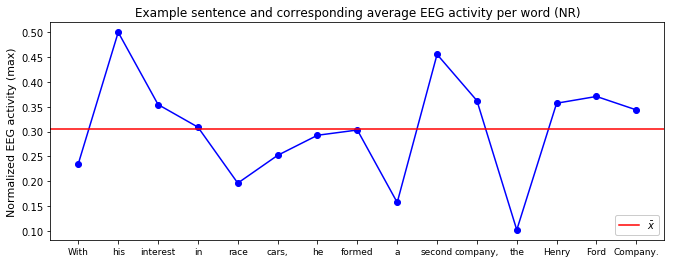

In [41]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

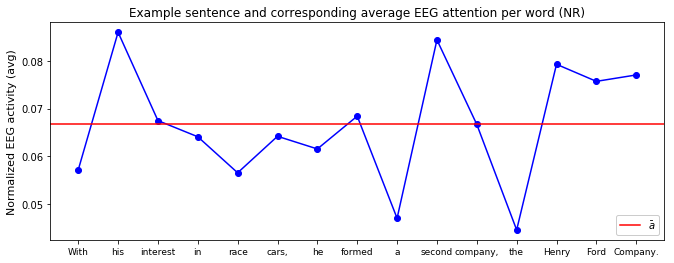

In [31]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG attention per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

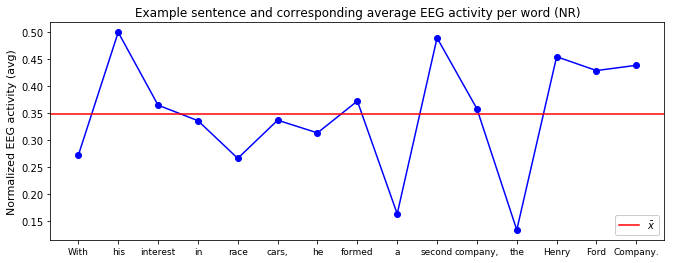

In [42]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

In [44]:
#os.mkdir('attention_weights')

In [29]:
weights_45d_RF_NR_Max.to_csv('./attention_weights/weights_45d_RF_NR_Max_softmax.csv', sep='\t', index=False, header=False)
weights_45d_RF_TSR_Max.to_csv('./attention_weights/weights_45d_RF_TSR_Max_softmax.csv', sep='\t', index=False, header=False)
weights_90d_RF_NR_Max.to_csv('./attention_weights/weights_90d_RF_NR_Max_softmax.csv', sep='\t', index=False, header=False)
weights_90d_RF_TSR_Max.to_csv('./attention_weights/weights_90d_RF_TSR_Max_softmax.csv', sep='\t', index=False, header=False)

weights_45d_RF_NR_Mean.to_csv('./attention_weights/weights_45d_RF_NR_Mean_softmax.csv', sep='\t', index=False, header=False)
weights_45d_RF_TSR_Mean.to_csv('./attention_weights/weights_45d_RF_TSR_Mean_softmax.csv', sep='\t', index=False, header=False)
weights_90d_RF_NR_Mean.to_csv('./attention_weights/weights_90d_RF_NR_Mean_softmax.csv', sep='\t', index=False, header=False)
weights_90d_RF_TSR_Mean.to_csv('./attention_weights/weights_90d_RF_TSR_Mean_softmax.csv', sep='\t', index=False, header=False)